In [1]:
import numpy as np
import random
random.seed(123)
class JackEs():
    def __init__(self):
        self.actions = {'hit':0 , 'stick': 1}
        self.pack = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10 ,10, 10]
        self.list_states()
        
    def pick_card(self):
        return np.random.choice(self.pack)
    
    def generate_dealer_card(self, card):
        pick_2 = self.pick_card()
        cards = [pick_2, card]
        for i, value in enumerate(cards):
            if value == 1:
                if 10 + sum(cards) <=21:
                    cards[i] =  11
                    return sum(cards), True

        return sum(cards), False
        
    
    def list_states(self):
        self.start_states = []
        self.states = []
#         for i in range(1,11):
        self.start_states.append((13, 2, True))
#             self.states.append(13, i, False)
        for i in range(4, 22):
            for j in range(1,11):
                self.states.append((i, j, True))
                self.states.append((i, j, False))
        
    
    def add_card_to_hand(self, card, player_cards, player_values):
#         print('Received card', card, player_cards)
        
        player_cards.append(card)
        if card != 1:
            
            player_values.append(card)
        else:
            if sum(player_values) + 11 <= 21:
                player_values.append(11)
            else:
                player_values.append(1)
    
    def generate_episodes(self, pi_s):
        init_state = random.choice(self.start_states)
#         print(init_state)
        
        episode_states = []
        episode_actions = []
        episode_rewards = []
        
        player_sum = init_state[0]
        dealer_card = init_state[1]
        usable_ace = init_state[-1]
#         print('player_sum',player_sum, 'dealer_card', dealer_card, 'usable_ace',usable_ace)
        dealer_sum, dealer_ace = self.generate_dealer_card(dealer_card)
        
        iter = 0
        done = False
        
        while not done:
#             print('iter', iter)
            episode_states.append((player_sum, dealer_card, usable_ace))
#             if iter == 0:
            action = np.random.choice([0,1],p=[0.5, 0.5])
#             else:
#                 action = pi_s[episode_states[-1]]
            episode_actions.append(action)
            
            if action == self.actions['hit']:
                next_card = self.pick_card()
#                 print('hit', episode_states[-1])
                if next_card + player_sum <= 21:
                    
                    if next_card == 1 and player_sum + 11 <= 21:
                        next_card = 11
                        usable_ace = True
                        
                    player_sum += next_card
                    done = False
                    reward = 0
                else:
                    if usable_ace:
                        if player_sum + next_card - 10 <= 21:
                            player_sum += (next_card -10)
                            usable_ace = False
                            done = False
                            reward = 0
                        else:
                            done = True
                            reward = -1
                            episode_rewards.append(reward)
                            break
                    else:
                        done = True
                        reward = -1
                        episode_rewards.append(reward)
                        break
            
            elif action == self.actions['stick']:
#                 print('stick')
                done = True
                while dealer_sum < 17:
                    next_d_card = self.pick_card()
                    if dealer_sum + next_d_card > 21:
                        if dealer_ace:
                            
                            dealer_ace = False
                            dealer_sum += next_d_card -10
                            
                        else:
                            dealer_sum += next_d_card
                    else:
                        dealer_sum += next_d_card
                        if next_d_card == 1 and (dealer_sum + 10) <= 21:
                            dealer_sum += 10
                            dealer_ace = True
                
                if dealer_sum > 21:
                    reward = 1
                    episode_rewards.append(1)
                    break
                
                else:
                    if dealer_sum == player_sum:
                        reward = 0
                    elif (21 - dealer_sum) < (21 - player_sum):
                        reward = -1
                    elif (21 - dealer_sum) > (21 - player_sum):
                        reward = 1
                    
            episode_rewards.append(reward)                            
            iter += 1
            
        return episode_states, episode_rewards, episode_actions
        

In [2]:
%matplotlib inline

In [7]:
jack = JackEs()
# jack.run(100)
q_sa = {}
pi_s = {}
V_s = {}
C = {}
for i in jack.states:
#     q_sa[(i, 0)] = [0. , 0]
#     q_sa[(i, 1)] = [0. , 0]
    q_sa[(i, 0)] = 0
    q_sa[(i, 1)] = 0
    if i[0] <= 21:
        pi_s[i] = 0
    else:
        pi_s[i] = 1
    C[(i, 0)] = 0
    C[(i, 1)] = 0
episodes = 10000
cmp_vals = []
out_errors = []
error_Val = -0.27726
num_runs = 1
for run in range(num_runs):
    errors = []
    for episode in range(episodes):
        G = 0
        Vn = 0
        W = 1

        if episode % 1000 == 0:
            print(episode)
        states, rewards, actions = jack.generate_episodes(pi_s)
        for j in reversed(range(len(states))):
            
            C[(states[j], actions[j])] += W 
            G += rewards[j]

            q_sa[(states[j], actions[j])] = q_sa[(states[j], actions[j])] + \
            W/(C[(states[j], actions[j])]+1e-5)  * (G  - q_sa[(states[j], actions[j])])
            if actions[j] == pi_s[states[j]]:
                W = W * 1/ 0.5
            else:
                W = 0
                break

    #         q_sa[(states[j], actions[j])][1] += 1
            if q_sa[(states[j], 0)] > q_sa[(states[j], 1)] and \
                                    states[j] == jack.start_states[0]:
                cmp_vals.append(q_sa[(states[j], 0)])
                error = (q_sa[(states[j], 0)] - error_Val)**2
#                 print(error)
            else:
                cmp_vals.append(q_sa[(states[j], 1)])
                error = (q_sa[(states[j], 1)] - error_Val)**2
            
            errors.append(error)
        out_errors.append(np.average(errors))
# print(np.array(errors).shape)

0
1000


/home/thor/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/thor/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2000
3000
4000
5000
6000
7000
8000
9000


In [10]:
import matplotlib.pyplot as plt

In [8]:
np.array(out_errors).shape

(10000,)

In [25]:
jack = JackEs()
# jack.run(100)
q_sa = {}
pi_s = {}
V_s = {}
C = {}
for i in jack.states:
#     q_sa[(i, 0)] = [0. , 0]
#     q_sa[(i, 1)] = [0. , 0]
    q_sa[(i, 0)] = 0
    q_sa[(i, 1)] = 0
    if i[0] <= 21:
        pi_s[i] = 0
    else:
        pi_s[i] = 1
    C[(i, 0)] = 0
    C[(i, 1)] = 0
episodes = 10000
cmp_vals = []
ord_errors = []
error_Val = -0.27726
num_runs = 1
for run in range(num_runs):
    errors = []
    for episode in range(episodes):
        G = 0
        Vn = 0
        W = 1

        if episode % 1000 == 0:
            print(episode)
        states, rewards, actions = jack.generate_episodes(pi_s)
        for j in reversed(range(len(states))):
            
            C[(states[j], actions[j])] += 1 
            G += rewards[j]

            q_sa[(states[j], actions[j])] = q_sa[(states[j], actions[j])] + \
            W/(C[(states[j], actions[j])]+1e-5)  * (G  - q_sa[(states[j], actions[j])])
            if actions[j] == pi_s[states[j]]:
                W = W * 1/ 0.5
            else:
                W = 0
                break

    #         q_sa[(states[j], actions[j])][1] += 1
            if q_sa[(states[j], 0)] > q_sa[(states[j], 1)] and \
                                    states[j] == jack.start_states[0]:
                cmp_vals.append(q_sa[(states[j], 0)])
                error = (q_sa[(states[j], 0)] - error_Val)**2
#                 print(error)
            else:
                cmp_vals.append(q_sa[(states[j], 1)])
                error = (q_sa[(states[j], 1)] - error_Val)**2
            
            errors.append(error)
        ord_errors.append(np.average(errors))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


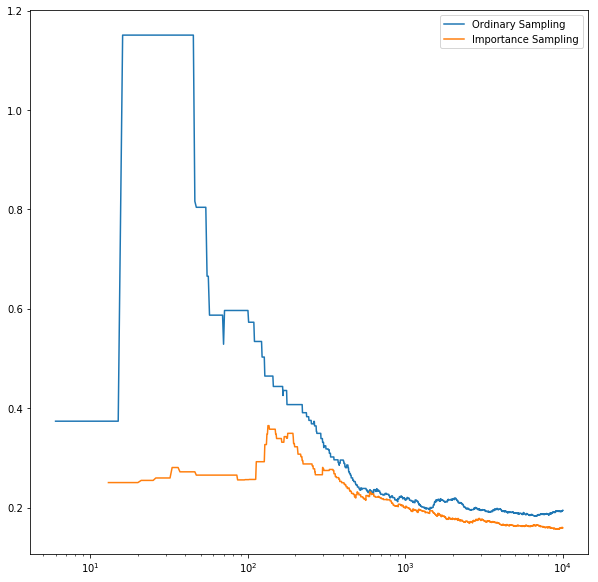

In [26]:
fig = plt.figure(figsize=(10,10))
plt.plot(ord_errors, label='Ordinary Sampling')
plt.plot(out_errors, label='Importance Sampling')
plt.xscale('log')
plt.legend()